![]("three_API.png")

# Getting Started with FastEstimator

## Overview
Welcome to FastEstimator(FE). In this tutorial we are going to cover:
* Three main APIs of FastEstimator: `Pipeline`, `Network`, `Estimator`
* Two basic logic units: `Op`, `Trace`
* How to express `Op` and `Trace` connection
* How mode works in `Op` and `Trace`
* Example code of image classification

## Three main APIs
All deep learning training workﬂows involve three essential components: data pipeline, network, and optimization plan. Data pipeline extracts data from disk to RAM, performs transformations, and then loads the data onto the device. Network stores trainable and differentiable graphs. Optimization strategy combines data pipeline and network in an iterative process. Each of these components represents a critical API in FastEstimator: `Pipeline`, `Network`, and `Estimator`. Users will interact with these three APIs for any deep learning task.

* `Pipeline`: Pipeline summarize Extraction-Transformation-Load (ETL) process. It contains the data source and data preprocessing operations. <br> <br>
* `Network`: Network manage trainable model and untrainable graph. <br> <br>
* `Estimator`: Estimator wrap up both `Pipeline` and `Netowrk` together, and defines what else to do in the training loop except for updating the model. 

<img src="../image/three_API.PNG" alt="drawing" width="700"/>

## Two basic logic units
If the three main APIs build the FastEstimator application, what build those APIs?.
The central component of Pipeline and Network is `Op`(Operator), and of Estimator is `Trace`. Operator and Trace are both core concepts which differentiate FastEstimator from other frameworks.

* `Op`: The logic unit in `Pipeline` and `Network`. In one hand they serve as data preprocessing step inside Pipeline. In the other hand they serve as data post-processing step, model function, and model update unit inside Network <br><br>
* `Trace`: The logic unit in `Estimator`. It is usually used as metric calculation or callback function for monitoring training and model saving.


## How to express `Op` and `Trace` connection
`Op` and `Trace` are the basic blocks composing FastEstimator network. But how these blocks connect to each other? 
FastEstimator express topology by sharing node names (keys) in blocks argument: `inputs` and `outputs`. 

### Create a new node 
Node names can be any string. If the node name doesn't exist yet, it will create a new node in the graph.

<img src="../image/connection1.PNG" alt="drawing" width="700"/>

### Overwrite a node
Nodes can be overwritten by a block's output, but the overwritten node can not be accessed in the next block. 

<img src="../image/connection3.PNG" alt="drawing" width="700"/>
In this example, the block B cannot access original node x after block A overwrote it.

### Multiple inputs and outputs
Some Ops and Trace can have multiple inputs and outputs.

<img src="../image/connection2.PNG" alt="drawing" width="700"/>

### Dynamic graph 
FastEstimator topology can vary in different epochs by using `Scheduler`. Please check out **Advanced tutorial: Scheduler** for more details. 

<img src="../image/connection4.PNG" alt="drawing" width="700"/>

## How mode works in `Op` and `Trace`
FastEstimator have four different graph: `train`, `eval`, `test`, `infer`. Each graph is completely independent with others and only one graph will be active at a time. Only when the mode is active does the graph with same name be activated.

* `train` mode: Activate `train` graph. The mode is on by calling Estimator.fit()  
* `eval` mode: Activate `eval` graph. The mode is on by calling Estimator.fit() after training phase, 
* `test` mode: Activate `test` graph. The mode is on by calling Estimator.test()
* `infer` mode: Activate `infer` graph. The mode is on by calling Pipeline.transform(), and Network.transform()

Mode argument in Trace and Op class is to specify which graph this object is going to be located. (In the other word, it specify which mode will activate this object) 

### How to specify mode
1. Specify single mode.<br> 
  ex: Op(mode="train") <br><br>

2. Specify multiple mode.<br>
  ex: Op(mode=["train", "test"]) <br><br>

3. Specify exception mode. Prefix a "!" on a mode, and then all other modes will activated this object. <br>
  ex: Op(mode="!train") <br><br>

4. Specify all modes. It is the default value of mode setting<br>
  ex: Op(mode=None)



## Code example for MNIST image classification 
All FastEstimator applications basically contain three main steps which repectively corresponds to three main APIs:
* Step 1: Data and Pipeline preparation
* Step 2: Network construction
* Step 3: Estimator definition 

Here we are going to demonstrate training MNIST image classification model with FastEstimator following these 3-steps process. The diagram illustrate the idea of how those APIs, `Ops`, and `Traces` connects in this specific case.

For more deep learning application examples, please check out our **Apphub** which have various end-to-end tutorials for many classic model. 

<img src="../image/MNIST_workflow.PNG" alt="drawing" width="700"/>

### Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation datasets and prepare FastEstimator's pipeline.
#### Load dataset
We use FastEstimator APIs to load the MNIST dataset and get the test set by splitting 50% evaluation set. Please check out **Beginner tutorial: FastEstimator Dataset** for more details.

In [1]:
import fastestimator as fe
from fastestimator.dataset.data import mnist

train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)

#### Set up preprocessing pipeline
For this example, the data preprocessing steps include:
* step 1: expand image dimension from (28,28) to (28, 28, 1)
* step 2: normalize pixel value in range of [0, 1]. <br>

We set up those processing steps using `Ops` and meanwhile declare the data source (MNIST) and batch size. Please check out **Beginner tutorial: Create Pipeline** for more details.

In [2]:
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), 
                            Minmax(inputs="x", outputs="x_out")])

### Step 2 - `Network` construction
#### Model construction
Here the model definition is going to be imported from the FastEstimator predefined architecture that is implemented in Tensorflow (FastEstimator support Pytorch implementation as well). We afterwards create model instance by compiling it with specific model optimizer. Please check out **Beginner tutorial: Create Model Instance** for more details.

In [3]:
from fastestimator.architecture.tensorflow import LeNet

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

#### `Network` definition
`Network` is a graph consisting of model(s) and its post-processing steps. `Ops` are its basic component that can either be logic for loss calculation, model update units, and even model. We set the mode of CrossEntropy and UpdateOp to !infer because those Ops are not needed in inference mode. Please check out **Beginner tutorial: Create Network** for more details. 

In [4]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp


network = fe.Network(ops=[
        ModelOp(model=model, inputs="x_out", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="!infer"),
        UpdateOp(model=model, loss_name="ce", mode="!infer") 
    ])

### Step 3 - `Estimator` definition and training
In this step, we define the `Estimator` to connect the `Network` with `Pipeline` and set the `traces` which compute accuracy (Accuracy), save best model (BestModelSaver). Please check out **Beginner tutorial: Create Estimator** for more details.

In [5]:
from fastestimator.schedule import cosine_decay
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
import tempfile

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")
]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         traces=traces,
                         max_steps_per_epoch=None)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.2845984; 
FastEstimator-Train: step: 100; ce: 0.36052123; steps/sec: 71.82; 
FastEstimator-Train: step: 200; ce: 0.09874984; steps/sec: 70.81; 
FastEstimator-Train: step: 300; ce: 0.20694208; steps/sec: 70.33; 
FastEstimator-Train: step: 400; ce: 0.060810007; steps/sec: 72.98; 
FastEstimator-Train: step: 500; ce: 0.10247067; steps/sec: 70.26; 
FastEstimator-Train: step: 600; ce: 0.27540103; steps/sec: 76.54; 
FastEstimator-Train: step: 700; ce: 0.05150436; steps/sec: 78.42

### Model Inference
After the model being trained, we want to test the model by running inference directly on some test data. Therefore we randomly select 5 images from testing dataset and infer them image by image with `Pipeline.transform` and `Netowork.transform`. Please checkout **Beginner tutorial: Inference** for more details. 

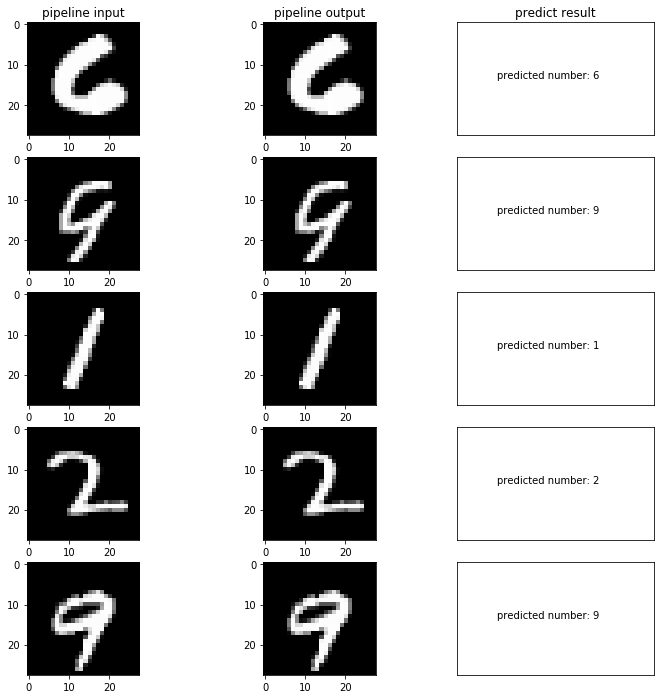

In [6]:
import matplotlib.pyplot as plt
import numpy as np

sample_num = 5

fig, axs = plt.subplots(sample_num, 3, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")
axs[0,2].set_title("predict result")

for i, j in enumerate(np.random.randint(low=0, high=31, size=sample_num)):
    data = {"x": test_data["x"][j]}
    axs[i,0].imshow(data["x"], cmap="gray")
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    img = data["x_out"].squeeze(axis=(0,3))
    axs[i,1].imshow(img, cmap="gray")
    
    # run the network
    data = network.transform(data, mode="infer")
    predict = data["y_pred"].numpy().squeeze(axis=(0))
    axs[i,2].text(0.2, 0.5, "predicted number: {}".format(np.argmax(predict)))
    axs[i,2].get_xaxis().set_visible(False)
    axs[i,2].get_yaxis().set_visible(False)